In [1]:
!pip install datasets
!pip install transformers
!pip3 install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 103.8 MB/s eta 0:0

In [2]:
!pip install transformers plotly==5.8.0 pyyaml==5.4.1 datasets pytorch-lightning > /dev/null 2>&1


In [3]:
from pprint import pprint
import functools

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification, CamembertForMaskedLM, AutoTokenizer, AutoConfig
from datasets import load_dataset
from sklearn.metrics import confusion_matrix, f1_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from tqdm.notebook import tqdm

In [4]:
camembert = CamembertForMaskedLM.from_pretrained('camembert-base')

In [5]:
camembert.roberta.embeddings

CamembertEmbeddings(
  (word_embeddings): Embedding(32005, 768, padding_idx=1)
  (position_embeddings): Embedding(514, 768, padding_idx=1)
  (token_type_embeddings): Embedding(1, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [6]:
print(f"Camembert est composé de {len(camembert.roberta.encoder.layer)} couches cachées\n")
print("Composition de la première couche :")
camembert.roberta.encoder.layer[0]

Camembert est composé de 12 couches cachées

Composition de la première couche :


CamembertLayer(
  (attention): CamembertAttention(
    (self): CamembertSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): CamembertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): CamembertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): CamembertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [7]:
def display_nb_params(model):
    param_size = 0
    param_count = 0
    for param in model.parameters():
        param_count += param.nelement()
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('Nombre de paramètres: {} | Poids du modèle: {:.2f}MB'.format(param_count, size_all_mb))

display_nb_params(camembert)

Nombre de paramètres: 110655493 | Poids du modèle: 422.13MB


In [8]:
tokenizer = AutoTokenizer.from_pretrained('camembert-base')

#tokenizer_output = tokenizer(batch_sentences)
#pprint(tokenizer_output, width=150)

In [10]:
def take_first_embedding(embeddings, attention_mask=None):
    return embeddings[:, 0]

def average_embeddings(embeddings, attention_mask):
    return (attention_mask[..., None] * embeddings).mean(1)

In [11]:
from datasets import list_datasets, load_dataset

dataset = load_dataset("miam", "loria")
dataset

Generating train split:   0%|          | 0/8465 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/942 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1047 [00:00<?, ? examples/s]

Dataset miam downloaded and prepared to /root/.cache/huggingface/datasets/miam/loria/1.0.0/3cb25c5337f9e60db1dc6d90344763a6ef79d7a4ac3c5f215ce6e8afe99db26c. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 8465
    })
    validation: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 942
    })
    test: Dataset({
        features: ['Speaker', 'Utterance', 'Dialogue_Act', 'Dialogue_ID', 'File_ID', 'Label', 'Idx'],
        num_rows: 1047
    })
})

In [12]:
pd_dataset = {split_name: split_data.to_pandas() for split_name, split_data in dataset.items()}
pd_dataset["validation"]

,Speaker,Utterance,Dialogue_Act,Dialogue_ID,File_ID,Label,Idx
0,Samir,Bravo! Vous avez été rapides!,greet,19,Dial_20110530_154627,5,0
1,Samir,Qu'est-ce que je peux faire pour vous?,ask,19,Dial_20110530_154627,1,1
2,Julie,merci,next_step,19,Dial_20110530_154627,17,2
3,Samir,"Eh bien, il va falloir la fabriquer cette mane...",inform,19,Dial_20110530_154627,7,3
4,Samir,"Mais sinon, vous avez encore des questions sur...",ask,19,Dial_20110530_154627,1,4
...,...,...,...,...,...,...,...
937,Julie,Avec plaisir!,yes,1239,Dial_20120104_160514,30,937
938,Sophia,C' est un métier pour lequel il faut être poly...,inform,1239,Dial_20120104_160514,7,938
939,Julie,"Oui, je vois.",ack,1239,Dial_20120104_160514,0,939
940,Sophia,"Je vous laisse les assembler , je les ai posé ...",quit,1239,Dial_20120104_160514,21,940


Le dataset comprend 31 labels.


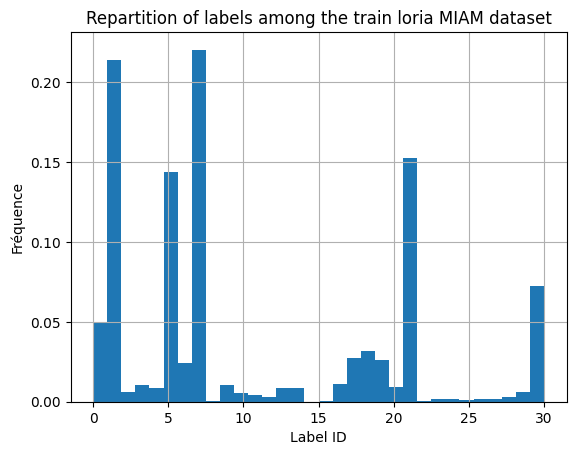

In [13]:
nb_labels = len(pd_dataset["train"]["Label"].unique())
print(f"Le dataset comprend {nb_labels} labels.")

ax = pd_dataset["train"]["Label"].hist(density=True, bins=nb_labels+1)
ax.set_xlabel("Label ID")
ax.set_ylabel("Fréquence")
ax.set_title("Repartition of labels among the train loria MIAM dataset")
ax.figure.show()

In [14]:
def tokenize_batch(samples, tokenizer):
    text = [sample["Utterance"] for sample in samples]
    labels = torch.tensor([sample["Label"] for sample in samples])
    str_labels = [sample["Dialogue_Act"] for sample in samples]
    # The tokenizer handles
    # - Tokenization (amazing right?)
    # - Padding (adding empty tokens so that each example has the same length)
    # - Truncation (cutting samples that are too long)
    # - Special tokens (in CamemBERT, each sentence ends with a special token </s>)
    # - Attention mask (a binary vector which tells the model which tokens to look at. For instance it will not compute anything if the token is a padding token)
    tokens = tokenizer(text, padding="longest", return_tensors="pt")

    return {"input_ids": tokens.input_ids, "attention_mask": tokens.attention_mask, "labels": labels, "str_labels": str_labels, "sentences": text}

In [15]:
camembert = camembert.cuda()

In [16]:
num_labels = dataset["train"].features["Label"].num_classes

In [17]:
from torch.utils.data import DataLoader
import functools

train_dataloader = DataLoader(
    dataset["train"], 
    batch_size=16, 
    shuffle=True, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)
val_dataloader = DataLoader(
    dataset["validation"], 
    batch_size=16, 
    shuffle=False, 
    collate_fn=functools.partial(tokenize_batch, tokenizer=tokenizer)
)

In [18]:
class LightningModel(pl.LightningModule):
    def __init__(self, model_name, num_labels, lr, weight_decay, from_scratch=False):
        super().__init__()
        self.save_hyperparameters()
        if from_scratch:
            # Si `from_scratch` est vrai, on charge uniquement la config (nombre de couches, hidden size, etc.) et pas les poids du modèle 
            config = AutoConfig.from_pretrained(
                model_name, num_labels=num_labels
            )
            self.model = AutoModelForSequenceClassification.from_config(config)
        else:
            # Cette méthode permet de télécharger le bon modèle pré-entraîné directement depuis le Hub de HuggingFace sur lequel sont stockés de nombreux modèles
            self.model = AutoModelForSequenceClassification.from_pretrained(
                model_name, num_labels=num_labels
            )
        self.lr = lr
        self.weight_decay = weight_decay
        self.num_labels = self.model.num_labels

    def forward(self, batch):
        return self.model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

    def training_step(self, batch):
        out = self.forward(batch)

        logits = out.logits
        # -------- MASKED --------
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits.view(-1, self.num_labels), batch["labels"].view(-1))

        # ------ END MASKED ------

        self.log("train/loss", loss)

        return loss

    def validation_step(self, batch, batch_index):
        labels = batch["labels"]
        out = self.forward(batch)

        preds = torch.max(out.logits, -1).indices
        # -------- MASKED --------
        acc = (batch["labels"] == preds).float().mean()
        # ------ END MASKED ------
        self.log("valid/acc", acc)

        f1 = f1_score(batch["labels"].cpu().tolist(), preds.cpu().tolist(), average="macro")
        self.log("valid/f1", f1)

    def predict_step(self, batch, batch_idx):
        """La fonction predict step facilite la prédiction de données. Elle est 
        similaire à `validation_step`, sans le calcul des métriques.
        """
        out = self.forward(batch)

        return torch.max(out.logits, -1).indices

    def configure_optimizers(self):
        return torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

In [19]:
lightning_model = LightningModel("camembert-base", num_labels, lr=3e-5, weight_decay=0.)


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [20]:
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor="valid/acc", mode="max")

camembert_trainer = pl.Trainer(
    max_epochs=20,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid/acc", patience=4, mode="max"),
        model_checkpoint,
    ]
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [21]:
camembert_trainer.fit(lightning_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)



INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                               | Params
-------------------------------------------------------------
0 | model | CamembertForSequenceClassification | 110 M 
-------------------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.583   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/pytorch_lightning/utilities/data.py:76: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 14. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [22]:
lightning_model = LightningModel.load_from_checkpoint(checkpoint_path=model_checkpoint.best_model_path)


Some weights of the model checkpoint at camembert-base were not used when initializing CamembertForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.out_proj.bias

In [23]:
ID_TO_LABEL = dataset["train"].features["Label"].names


In [ ]:
ID_TO_LABEL

['ack',
 'ask',
 'find_mold',
 'find_plans',
 'first_step',
 'greet',
 'help',
 'inform',
 'inform_engine',
 'inform_job',
 'inform_material_space',
 'informer_conditioner',
 'informer_decoration',
 'informer_elcomps',
 'informer_end_manufacturing',
 'kindAtt',
 'manufacturing_reqs',
 'next_step',
 'no',
 'other',
 'quality_control',
 'quit',
 'reqRep',
 'security_policies',
 'staff_enterprise',
 'staff_job',
 'studies_enterprise',
 'studies_job',
 'todo_failure',
 'todo_irreparable',
 'yes']

In [24]:
def get_preds(model, tokenizer, sentence):
    tokenized_sentence = tokenizer(sentence, return_tensors="pt")
    input_ids, attention_mask = tokenized_sentence.input_ids, tokenized_sentence.attention_mask

    out = model(
        input_ids=tokenized_sentence.input_ids,
        attention_mask=tokenized_sentence.attention_mask
    )

    logits = out.logits

    probas = torch.softmax(logits, -1).squeeze()

    pred = torch.argmax(probas)

    return ID_TO_LABEL[pred], probas[pred].item()

In [25]:
test_sentence = "Bonjour Monsieur"

label_predicted, proba = get_preds(lightning_model.model, tokenizer, test_sentence)

print(f"Label: {label_predicted}, confidence: {proba:.2f}")

Label: greet, confidence: 1.00


In [119]:
camembert_preds = camembert_trainer.predict(lightning_model, dataloaders=val_dataloader)
camembert_preds = torch.cat(camembert_preds, -1)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

In [27]:
import numpy as np

def plot_confusion_matrix(labels, preds, label_names):
    confusion_norm = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))), normalize="true")
    confusion = confusion_matrix(labels, preds.tolist(), labels=list(range(len(label_names))))
    
    plt.figure(figsize=(16, 14))
    sns.heatmap(
        confusion_norm,
        annot=confusion,
        cbar=False,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names,
        cmap="viridis"
    )
    print(confusion.trace(),  np.sum(confusion))

819 942


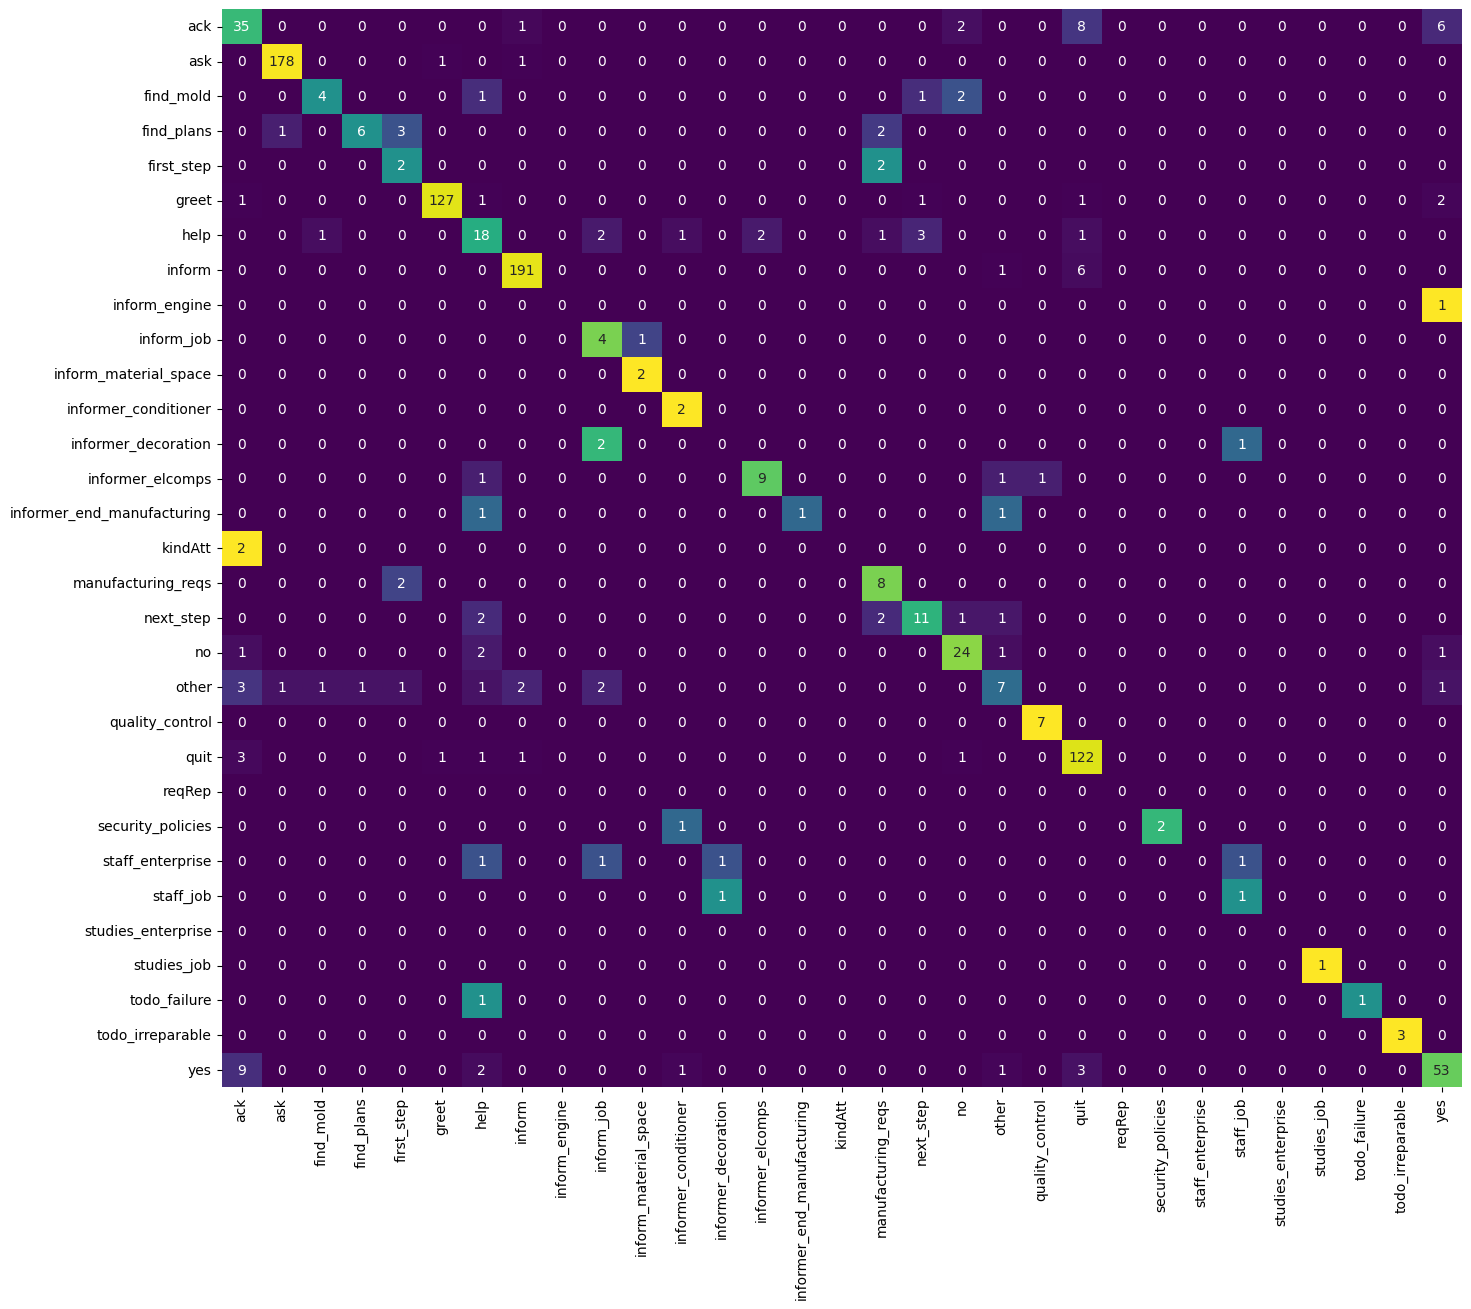

In [28]:
label_names = dataset["validation"].features["Label"].names
labels = dataset["validation"]["Label"]

plot_confusion_matrix(labels, camembert_preds, label_names)


In [136]:
from typing_extensions import ParamSpecKwargs
import random

def add_neighbour_error(text, frequency = 0.05, close_letter = True):
  n_error = int(len(text)*frequency)
  dic_error = {"q":["a","w"], "w":["a","e","s","q"], "e":["z","r","d","s"], "r":["e","d","f","t"],"t":["r","f","g","h","y"],"y":["t","g","h","j","u"],"i":["u","j","k","l","o"],"p":["o","l","m"],
               "a":["q","w","s","z"], "s":["a","z","e","d","x","w"],"d":["s","x","c","f","r","e"],"f":["d","r","t","g","v","c"], "g":["f","v","t","y","h","b"], "h":["g","y","u","j","n","b"], "j":["h","u","i","k","n"], "k":["l","o","i"], "l":["m","k","o"], "m":["l","p"],
               "z":["q","s","x"], "x":["z","s","c","d"], "c":["x","d","f","v"], "v":["c","f","g","b"], "b":["v","g","h","n"], "n":["b","h","j"]}
  list_alpha = list("azertyuiopqsdfghjklmwxcvbn")
  str_alpha = "azertyuiopqsdfghjklmwxcvbn"
  possible_choice = list()
  for i in range(len(text)):
    if text[i] in list(dic_error):
      possible_choice.append(i)
  
  to_change = random.sample(possible_choice, min(n_error, len(possible_choice)))

  out = ""
  for index in range(len(text)):
    if index in to_change:
      if close_letter:
        out = out + random.choice(dic_error[text[index]])
      else:
        out = out + random.choice(list(str_alpha.replace(text[index],'')))
    else:
      out = out + text[index]
  
  return out

def add_switch_error(text, frequency = 0.05, close_letter = True):
  n_error = int(len(text)*frequency)

  list_alpha = list("azertyuiopqsdfghjklmwxcvbn")
  possible_choice = list()
  for i in range(len(text)-1):
    if text[i] in list_alpha:
      possible_choice.append(i)
  
  to_change = random.sample(possible_choice, min(n_error, len(possible_choice)))

  out = ""
  index = 0
  while index < len(text):
    if index in to_change:
      out = out + text[index+1]
      out = out + text[index]
      index += 2
    else:
      out = out + text[index]
      index += 1
  
  return out

def add_missing_error(text, frequency = 0.05, close_letter = True):
  n_error = int(len(text)*frequency)

  list_alpha = list("azertyuiopqsdfghjklmwxcvbn")
  possible_choice = list()
  for i in range(len(text)-1):
    if text[i] in list_alpha:
      possible_choice.append(i)
  
  to_change = random.sample(possible_choice, min(n_error, len(possible_choice)))

  out = ""

  for index in range(len(text)):
    if index in to_change:
      pass
    else:
      out = out + text[index]
  
  return out

def add_double_error(text, frequency = 0.05, close_letter = True):
  n_error = int(len(text)*frequency)

  list_alpha = list("azertyuiopqsdfghjklmwxcvbn")
  possible_choice = list()
  for i in range(len(text)-1):
    if text[i] in list_alpha:
      possible_choice.append(i)
  
  to_change = random.sample(possible_choice, n_error)

  out = ""

  for index in range(len(text)):
    if index in to_change:
      out = out + text[index] + text[index] 
    else:
      out = out + text[index]
  
  return out

In [142]:
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
functions = [add_neighbour_error,add_switch_error,add_missing_error,add_double_error]

rate_of_well_predicted = list() 
for function in functions:
  modified_utts = list()
  for ind, utt in enumerate(dataset["validation"]['Utterance']):
    #print(utt, dataset["validation"]["Label"][ind])
    modified_utt = function(utt, frequency = 0.05, close_letter = True)
    label_predicted, proba = get_preds(lightning_model.model, tokenizer, modified_utt)
    modified_utts.append([modified_utt,ID_TO_LABEL[dataset["validation"]["Label"][ind]], label_predicted, proba])
  modified_df = pd.DataFrame(modified_utts, columns=['Utterance', "Label","Predicted_label", "proba"])
  # Calculer la matrice de confusion
  confusion_mat = confusion_matrix(modified_df['Label'], modified_df['Predicted_label'])
  print(confusion_mat.trace(),  np.sum(confusion_mat))
  rate_of_well_predicted.append(confusion_mat.trace() /  np.sum(confusion_mat))

782 942
785 942
789 942
798 942


In [138]:

#print(modified_utts[0])


,Utterance,Label,Predicted_label,proba
0,Bravo! Vous avez été rpides!,greet,greet,0.999079
1,Qu'est-ce que je peux faire our vous?,ask,ask,0.998629
2,merci,next_step,no,0.782545
3,"Eh bien, il va faloir la fabriquer cette manet...",inform,inform,0.999058
4,"Mis sinon, vous avez enore des questions sur l...",ask,ask,0.990429


788 942
